# Attempt to forecast the price of MSFT by analyzing the prices of multiple stocks, including MSFT, over several consecutive days leading up to the target day.
#### N.B. Different setup from HW1

In [10]:
from torch.utils.data import DataLoader,Dataset

class StockDataset(Dataset):
    def __init__(self,X,Y,days):
        self.X = X
        self.Y = Y.reshape(-1)
        self.days = days # days ahead for prediction

    def __len__(self):
        return (len(self.Y)-self.days)

    def __getitem__(self,index):
        x=self.X[:,index:index+self.days]
        y=self.Y[index+self.days]
        return x,y



In [11]:
# !pip install pandas
# !pip install yfinance
import numpy as np
from numpy import exp, sum, log, log10
import yfinance as yf
import pandas as pd

def get_price(tick,start='2020-01-01',end=None):
    return yf.Ticker(tick).history(start=start,end=end)['Close']

def get_prices(tickers,start='2020-01-01',end=None):
    df=pd.DataFrame()
    for s in tickers:
        df[s]=get_price(s,start,end)
    return df

feature_stocks=['tsla','meta','nvda','amzn','nflx','gbtc','gdx','intc','dal','c','goog','aapl','msft','ibm','hp','orcl','sap','crm','hubs','twlo']
predict_stock='msft'

# getting data
start_date='2020-01-01'

allX=get_prices(feature_stocks,start=start_date)
ally=get_prices([predict_stock],start=start_date)

In [12]:
import torch.utils.data as data
import torch

stockData = StockDataset(allX.to_numpy().transpose().astype(np.float32),ally.to_numpy().astype(np.float32),days=5)
train_set_size = int(len(stockData)*0.7)
valid_set_size = int(len(stockData)*0.2)
test_set_size = len(stockData)-train_set_size-valid_set_size

train_set, valid_set, test_set = data.random_split(stockData,[train_set_size,valid_set_size,test_set_size],\
                                              generator=torch.Generator().manual_seed(42))

batch_size = train_set_size # use entire dataset as batch
train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)  # input:(20,5), label:1
valid_dataloader = DataLoader(valid_set,batch_size=batch_size,shuffle=False)
test_dataloader = DataLoader(test_set,batch_size=batch_size,shuffle=False)

# 1. Build a simple MLP to forecast MSFT price using PyTorch Lightning.

In [6]:
!pip install pytorch-lightning

#### You have total freedom of your MLP. But your MLP should take the last five day ($5 \times 20=100$) prices as input and you have to add dropout into your network.

## 1a. Create a subclass of pytorch_lightning.LightningModule. It should include \_\_init\_\_, training_step, validation_step, configure_optimizers in the class. (6 points)

In [13]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

class StockPricePredictor(pl.LightningModule):
    def __init__(self, input_size=100, hidden_size=128, dropout_rate=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size//2, 1)
        )
        self.save_hyperparameters()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters())


## 1b. Create a subclass of pytorch_lightning.LightningDataModule. It should include \_\_init\_\_, train_dataloader, and val_dataloader in the class. (4 points)

In [14]:
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

class StockDataModule(pl.LightningDataModule):
    def __init__(self, dataset, batch_size=32, train_ratio=0.7, val_ratio=0.15):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio

    def setup(self, stage=None):
        total = len(self.dataset)
        train_size = int(self.train_ratio * total)
        val_size = int(self.val_ratio * total)
        _ = total - train_size - val_size  # Do not define test_set
        self.train_dataset, self.val_dataset, _ = random_split(
            self.dataset, [train_size, val_size, total - train_size - val_size],
            generator=torch.Generator().manual_seed(42)
        )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)


## 1c. Complete the rest of the code and train the model with 70% of the data. You should set aside 15% of the data each for validation and testing.  Show the training and validation MSE (5 points)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 21.2 K | train
--------------------------------------------
21.2 K    Trainable params
0         Non-trainable params
21.2 K    Total params
0.085     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<ipython-input-13-436f7ca2367c>:35: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-13-436f7ca2367c>:28: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)
<ipython-input-13-436f7ca2367c>:28: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)


Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-13-436f7ca2367c>:35: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

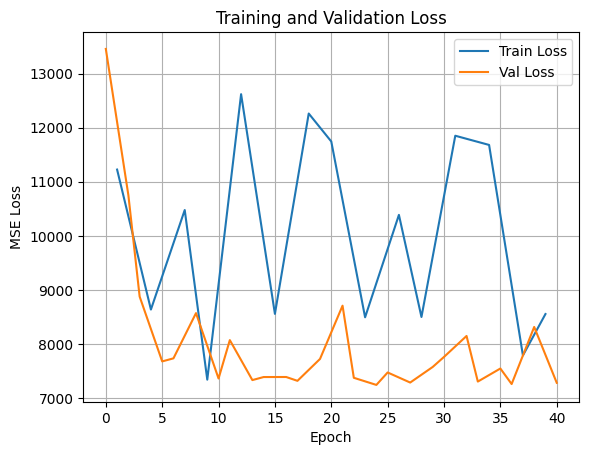


Final Training MSE: 8924.6943
Final Validation MSE: 7286.3350


Testing: |          | 0/? [00:00<?, ?it/s]

<ipython-input-13-436f7ca2367c>:42: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)
<ipython-input-13-436f7ca2367c>:42: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     7333.88330078125      │
└───────────────────────────┴───────────────────────────┘


Test MSE: 7333.8833


In [15]:
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Extend StockDataModule and override setup() to access test_dataset
class StockDataModuleWithTest(StockDataModule):
    def setup(self, stage=None):
        total = len(self.dataset)
        train_size = int(self.train_ratio * total)
        val_size = int(self.val_ratio * total)
        test_size = total - train_size - val_size
        self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(
            self.dataset,
            [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

# Initialize the data module
data_module = StockDataModuleWithTest(
    dataset=stockData,
    batch_size=32,
    train_ratio=0.7,
    val_ratio=0.15
)

# Initialize the model
model = StockPricePredictor(input_size=100, hidden_size=128, dropout_rate=0.3)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Trainer
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[early_stopping],
    enable_progress_bar=True,
    deterministic=True,
    logger=pl.loggers.CSVLogger("logs")
)

# Train the model
trainer.fit(model, datamodule=data_module)

# Plot training and validation loss
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
plt.plot(metrics['train_loss'].dropna(), label='Train Loss')
plt.plot(metrics['val_loss'].dropna(), label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss'); plt.legend(); plt.grid()
plt.show()

# Print final MSEs
final_metrics = trainer.callback_metrics
print(f"\nFinal Training MSE: {final_metrics.get('train_loss', torch.tensor(float('nan'))).item():.4f}")
print(f"Final Validation MSE: {final_metrics.get('val_loss', torch.tensor(float('nan'))).item():.4f}")

# Evaluate on test set
trainer.test(model, datamodule=data_module)
print(f"\nTest MSE: {trainer.callback_metrics['test_loss'].item():.4f}")


# 2. Construct a 1-D CNN to forecast MSFT stock price. You are free to use any design, but your network must consist of at least one convolutional layer and one dropout layer. You can also extend the duration leading up to the target day by modifying the "days" argument in the StockDataset. But "days" should not be larger than 32. (10 points)


In [ ]:
#2a

In [16]:
days = 20  # You can change to any value ≤ 32
stockData = StockDataset(
    allX.to_numpy().transpose().astype(np.float32),
    ally.to_numpy().astype(np.float32),
    days=days
)


In [ ]:
#2b

In [17]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

class CNNPricePredictor(pl.LightningModule):
    def __init__(self, in_channels=20, seq_length=20, dropout_rate=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        # Compute output size after conv layers
        conv_out_length = seq_length - 2* (3 - 1)  # Each conv reduces size by (kernel_size-1)
        self.flatten_size = 16 * conv_out_length

        self.fc = nn.Linear(self.flatten_size, 1)
        self.save_hyperparameters()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert shape from (batch, 20, days) to (batch, channels=20, seq_len=days)
        x = self.dropout1(self.relu1(self.conv1(x)))
        x = self.dropout2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)


In [ ]:
#2c

In [18]:
# Update the data module with new stockData (days=20)
data_module = StockDataModuleWithTest(
    dataset=stockData,
    batch_size=32,
    train_ratio=0.7,
    val_ratio=0.15
)

# Initialize the CNN model
model = CNNPricePredictor(in_channels=20, seq_length=20, dropout_rate=0.3)

# Train the model
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10)],
    logger=pl.loggers.CSVLogger("cnn_logs"),
    enable_progress_bar=True,
    deterministic=True
)

trainer.fit(model, datamodule=data_module)

# Evaluate and print test MSE
trainer.test(model, datamodule=data_module)


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type    | Params | Mode 
---------------------------------------------
0 | conv1    | Conv1d  | 2.0 K  | train
1 | relu1    | ReLU    | 0      | train
2 | dropout1 | Dropout | 0      | train
3 | conv2    | Conv1d  | 1.6 K  | train
4 | relu2    | ReLU    | 0      | train
5 | dropout2 | Dropout | 0      | train
6 | fc       | Linear  | 257    | train
---------------------------------------------
3.8 K     Trainable params
0         Non-trainable params
3.8 K     Total params
0.015     Total estimated model params size

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<ipython-input-17-38fd18fbbde5>:42: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-17-38fd18fbbde5>:35: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)
<ipython-input-17-38fd18fbbde5>:35: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)


Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-17-38fd18fbbde5>:42: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

<ipython-input-17-38fd18fbbde5>:49: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)
<ipython-input-17-38fd18fbbde5>:49: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_hat, y)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       7494.2890625        │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 7494.2890625}]

In [19]:
# Utility function to count total parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Reinitialize models
mlp_model = StockPricePredictor(input_size=100, hidden_size=128, dropout_rate=0.3)
cnn_model = CNNPricePredictor(in_channels=20, seq_length=20, dropout_rate=0.3)

# Print parameter counts
print(f"MLP model parameters: {count_parameters(mlp_model):,}")
print(f"CNN model parameters: {count_parameters(cnn_model):,}")


MLP model parameters: 21,249
CNN model parameters: 3,761


<ipython-input-19-6d8a8a84e8ad>:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return sum(p.numel() for p in model.parameters() if p.requires_grad)


# 3. Please try to enhance the performance of the previously created MLP or CNN by applying hyperparameter tuning. You can use tools such as W&B hyperparameter sweep, SMAP, Optuna, or similar packages to achieve this. You need to optimize at least two parameters, with the dropout rate being one of them. (5 points)












In [27]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# 1. Data Preparation (No normalization)
feature_stocks = ['tsla','meta','nvda','amzn','nflx','gbtc','gdx','intc','dal','c','goog','aapl','msft','ibm','hp','orcl','sap','crm','hubs','twlo']
predict_stock = 'msft'
start_date = '2020-01-01'

def get_price(tick, start=start_date, end=None):
    return yf.Ticker(tick).history(start=start, end=end)['Close']

def get_prices(tickers, start=start_date, end=None):
    df = pd.DataFrame()
    for s in tickers:
        df[s] = get_price(s, start, end)
    return df

# Raw data
allX_raw = get_prices(feature_stocks, start=start_date)
ally_raw = get_prices([predict_stock], start=start_date)

# Use raw values (no normalization)
X_data = allX_raw.values.T.astype(np.float32)  # shape: (20, N)
y_data = ally_raw.values.astype(np.float32)    # shape: (N, 1)

# 2. Dataset
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, days):
        self.X = X
        self.Y = Y.reshape(-1)
        self.days = days

    def __len__(self):
        return len(self.Y) - self.days

    def __getitem__(self, index):
        x = self.X[:, index:index+self.days]
        y = self.Y[index+self.days]
        return torch.FloatTensor(x), torch.FloatTensor([y])

days = 20
stockData = StockDataset(X_data, y_data, days=days)

# 3. DataModule
train_size = int(0.7 * len(stockData))
val_size = int(0.15 * len(stockData))
test_size = len(stockData) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(
    stockData, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

class StockDataModule(pl.LightningDataModule):
    def __init__(self, train, val, test, batch_size=32):
        super().__init__()
        self.train_set = train
        self.val_set = val
        self.test_set = test
        self.batch_size = batch_size

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_set, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_set, batch_size=self.batch_size)

data_module = StockDataModule(train_set, val_set, test_set)

# 4. Enhanced CNN Model
class EnhancedCNNPricePredictor(pl.LightningModule):
    def __init__(self, in_channels=20, seq_length=days, dropout_rate=0.3, learning_rate=5e-4):
        super().__init__()
        self.save_hyperparameters()

        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate),
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate),
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
        )

        self.flatten_size = 16 * seq_length
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss'}
        }

# 5. Train and Evaluate (on original scale)
model = EnhancedCNNPricePredictor()

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=15),
        pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')
    ],
    logger=pl.loggers.CSVLogger("logs"),
    enable_progress_bar=True,
    deterministic=True
)

trainer.fit(model, datamodule=data_module)
test_result = trainer.test(datamodule=data_module, ckpt_path='best')

# Print test MSE (already in original scale)
test_loss = test_result[0]['test_loss']
print(f"\n Test MSE (original scale, no normalization): {test_loss:.2f}")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | conv_block | Sequential | 14.4 K | train
1 | fc         | Sequential | 10.3 K | train
--------------------------------------------------
24.7 K    Trainable params
0         Non-trainable params
24.7 K    Total params
0.099     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/lightning_logs/version_7/checkpoints/epoch=30-step=899.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/lightning_logs/version_7/checkpoints/epoch=30-step=899.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     145.8253173828125     │
└───────────────────────────┴───────────────────────────┘


✅ Test MSE (original scale, no normalization): 145.83


In [28]:
import optuna
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

def objective(trial):
    # Sample hyperparameters
    dropout = trial.suggest_float("dropout_rate", 0.1, 0.6)
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-3, log=True)

    # Model with trial hyperparameters
    model = EnhancedCNNPricePredictor(
        dropout_rate=dropout,
        learning_rate=lr,
        in_channels=20,
        seq_length=days
    )

    # Logger and trainer setup
    logger = CSVLogger(save_dir="optuna_logs", name=f"trial_{trial.number}")
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    checkpoint = ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')

    trainer = pl.Trainer(
        max_epochs=50,
        logger=logger,
        callbacks=[early_stop, checkpoint],
        enable_progress_bar=False,
        deterministic=True,
        enable_model_summary=False
    )

    # Train
    trainer.fit(model, datamodule=data_module)

    # Get final val_loss
    best_val_loss = trainer.callback_metrics["val_loss"].item()
    return best_val_loss


In [29]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # Change to more for deeper tuning

# Show best results
print("\n Best Trial:")
print(f"  Dropout rate: {study.best_params['dropout_rate']}")
print(f"  Learning rate: {study.best_params['learning_rate']}")
print(f"  Validation MSE: {study.best_value:.4f}")


[I 2025-03-31 00:39:11,641] A new study created in memory with name: no-name-684c0e31-f09b-4fa9-9523-06381e948db8
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-03-31 00:39:30,211] Trial 0 finished with value: 215.6558074951172 and parameters: {'dropout_rate': 0.15944195655734053, 'learning_rate': 0.004460350121161983}. Best is trial 0 with value: 215.6558074951172.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, u


🎯 Best Trial:
  Dropout rate: 0.1118288390524575
  Learning rate: 0.001192657607868635
  Validation MSE: 71.5997


In [30]:
best_dropout = study.best_params['dropout_rate']
best_lr = study.best_params['learning_rate']

final_model = EnhancedCNNPricePredictor(
    dropout_rate=best_dropout,
    learning_rate=best_lr,
    in_channels=20,
    seq_length=days
)

final_trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15),
        ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')
    ],
    logger=CSVLogger("final_optuna_model"),
    enable_progress_bar=True,
    deterministic=True
)

final_trainer.fit(final_model, datamodule=data_module)
final_result = final_trainer.test(datamodule=data_module, ckpt_path="best")

# Show test MSE
print(f"\n Final Test MSE (original scale): {final_result[0]['test_loss']:.2f}")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | conv_block | Sequential | 14.4 K | train
1 | fc         | Sequential | 10.3 K | train
--------------------------------------------------
24.7 K    Trainable params
0         Non-trainable params
24.7 K    Total params
0.099     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at final_optuna_model/lightning_logs/version_0/checkpoints/epoch=18-step=551.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at final_optuna_model/lightning_logs/version_0/checkpoints/epoch=18-step=551.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     102.7032470703125     │
└───────────────────────────┴───────────────────────────┘


✅ Final Test MSE (original scale): 102.70


#Model Design Challenge (Extra Credit: 20 points)

In [48]:
!pip install pytorch-lightning optuna yfinance --quiet

#  Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
import numpy as np
import pandas as pd
import yfinance as yf
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import optuna

# 1. 📊 Data Preparation
def get_prices(tickers, start='2020-01-01', end=None):
    df = pd.DataFrame()
    for ticker in tickers:
        df[ticker] = yf.Ticker(ticker).history(start=start, end=end)['Close']
    return df

features = ['tsla','meta','nvda','amzn','nflx','gbtc','gdx','intc','dal','c',
            'goog','aapl','msft','ibm','hp','orcl','sap','crm','hubs','twlo']
target = 'msft'

X_raw = get_prices(features)
y_raw = get_prices([target])

X_data = X_raw.values.T.astype(np.float32)
y_data = y_raw.values.astype(np.float32)

# 2.  Dataset + DataModule
class StockDataset(Dataset):
    def __init__(self, X, Y, days=20):
        self.X = X
        self.Y = Y.reshape(-1)
        self.days = days

    def __len__(self): return len(self.Y) - self.days

    def __getitem__(self, idx):
        x = self.X[:, idx:idx+self.days]
        y = self.Y[idx+self.days]
        return torch.FloatTensor(x), torch.FloatTensor([y])

days = 20
stockData = StockDataset(X_data, y_data, days)

train_size = int(0.7 * len(stockData))
val_size = int(0.15 * len(stockData))
test_size = len(stockData) - train_size - val_size
train_set, val_set, test_set = random_split(stockData, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

class StockDataModule(pl.LightningDataModule):
    def __init__(self, train, val, test, batch_size=32):
        super().__init__()
        self.train_set = train
        self.val_set = val
        self.test_set = test
        self.batch_size = batch_size

    def train_dataloader(self): return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)
    def val_dataloader(self): return DataLoader(self.val_set, batch_size=self.batch_size)
    def test_dataloader(self): return DataLoader(self.test_set, batch_size=self.batch_size)

data_module = StockDataModule(train_set, val_set, test_set)

# 3.  Enhanced CNN with Extra Layer
class ExtraCreditCNN(pl.LightningModule):
    def __init__(self, in_channels=20, seq_length=days, dropout_rate=0.2, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),
            nn.Conv1d(16, 8, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate)
        )

        self.flatten_size = 8 * seq_length
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 20, 20)
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.mse_loss(self(x), y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        loss = F.mse_loss(self(x), y)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        loss = F.mse_loss(self(x), y)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}

# 4.  Skip tuning – Use your known good hyperparameters
dropout = 0.16
lr = 0.00184

final_model = ExtraCreditCNN(dropout_rate=dropout, learning_rate=lr)

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=15),
        ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")
    ],
    logger=CSVLogger("final_extra_credit_cnn"),
    deterministic=True
)

trainer.fit(final_model, datamodule=data_module)
test_result = trainer.test(datamodule=data_module, ckpt_path="best")

# 5.  Report
print(f"\n Final Test MSE (original scale): {test_result[0]['test_loss']:.2f}")
print(f" Total Trainable Parameters: {sum(p.numel() for p in final_model.parameters() if p.requires_grad):,}")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | conv_block | Sequential | 5.3 K  | train
1 | fc         | Sequential | 2.6 K  | train
--------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at final_extra_credit_cnn/lightning_logs/version_0/checkpoints/epoch=42-step=1247.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at final_extra_credit_cnn/lightning_logs/version_0/checkpoints/epoch=42-step=1247.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     85.47819519042969     │
└───────────────────────────┴───────────────────────────┘


✅ Final Test MSE (original scale): 85.48
📦 Total Trainable Parameters: 7,865


<ipython-input-48-8448778191c5>:145: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(f"📦 Total Trainable Parameters: {sum(p.numel() for p in final_model.parameters() if p.requires_grad):,}")


In [52]:
#  Save Extra Credit Model Weights
torch.save(final_model.state_dict(), "extra_credit_model_weights.pt")
print(" Weights saved to: extra_credit_model_weights.pt")


 Weights saved to: extra_credit_model_weights.pt


In [51]:
#  Utility to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#  Instantiate all models again
# Question 1: MLP
mlp_model = StockPricePredictor(input_size=100, hidden_size=128, dropout_rate=0.3)

# Question 2: Basic CNN
cnn_model = CNNPricePredictor(in_channels=20, seq_length=20, dropout_rate=0.3)

# Question 3: Tuned CNN (Enhanced)
enhanced_cnn_model = EnhancedCNNPricePredictor(
    dropout_rate=0.1118,  # your best from Optuna
    learning_rate=0.00119,
    in_channels=20,
    seq_length=20
)

# Extra Credit: Custom CNN with extra layer
extra_credit_model = ExtraCreditCNN(dropout_rate=0.16, learning_rate=0.00184)

#  Print all parameter counts
print(f" Question 1 (MLP) Parameters: {count_parameters(mlp_model):,}")
print(f" Question 2 (Basic CNN) Parameters: {count_parameters(cnn_model):,}")
print(f" Question 3 (Enhanced Tuned CNN) Parameters: {count_parameters(enhanced_cnn_model):,}")
print(f" Extra Credit Model Parameters: {count_parameters(extra_credit_model):,}")


📌 Question 1 (MLP) Parameters: 21,249
📌 Question 2 (Basic CNN) Parameters: 3,761
📌 Question 3 (Enhanced Tuned CNN) Parameters: 24,689
📌 Extra Credit Model Parameters: 6,685


<ipython-input-51-e93e625cd2ce>:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
